In [184]:
# load general packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate

# Import user generated functions
import functions as funcs

%load_ext autoreload
%autoreload 2

## Uncomment for nicer plots ##
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
plt.rc('axes', axisbelow=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load model data and plot

Load the data and save the wealth distribution. The distributions is generated from an external matlab file 'model.m'.

In [2]:
# Load the matlab generated wealth distribution
df_g = pd.read_csv(r'ga_var.csv', header=None)
df_a = pd.read_csv(r'a_var.csv', header=None)

# Save as a numpy array
g_bottom = df_g.to_numpy()
w_bottom = df_a.to_numpy()
g_bottom = np.array(g_bottom).ravel() # Remove outer brackets
w_bottom = np.array(w_bottom).ravel()

Manually add a right tail to the wealth distribution

In [158]:
# Define variables
alpha = 1.5
mu = -0.3
np.random.seed(214)

In [4]:
C = g_bottom[-1] / 2000**(-alpha-1)
tail_vals = np.linspace(w_bottom[-1],1_000_000, 100000)

g_top = C*tail_vals**(-alpha-1) # alpha value 1.5

Combine the two distributions and define grid of wealth levels associated with $g(w)$

In [5]:
g = np.append(g_bottom[:-1], g_top)
w = np.append(w_bottom[:-1], tail_vals)

Test if i can normalize the distribution

In [6]:
# Numeric integral over the support
integral = np.dot(g,w)

# Normalize
# g = g / integral

Plot the distribution of wealth

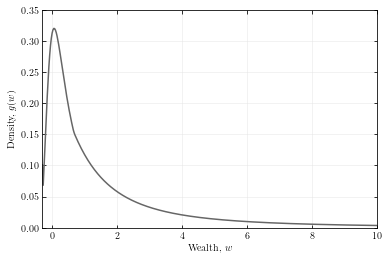

In [197]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.grid(b=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9', zorder=0)
ax.tick_params(axis='both', bottom=True, top=True, left=True, right=True, direction='in', which='both')

ax.plot(w, g, color = '0.4', zorder = 2, label = r'$g(a)$')

ax.set_xlim(-0.3,10)
ax.set_ylim(0,0.35)

ax.set_xlabel(r'Wealth, $w$')
ax.set_ylabel(r'Density, $g(w)$')

# ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

plt.savefig('../../tex/figs/model.pdf')

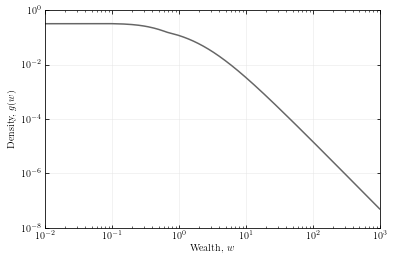

In [199]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.grid(b=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9', zorder=0)
ax.tick_params(axis='both', bottom=True, top=True, left=True, right=True, direction='in', which='both')

ax.plot(w, g, color = '0.4', zorder = 2, label = r'$g(a)$')
ax.set(xscale='log', yscale = 'log')

ax.set_xlim(1e-2,1e+3)
ax.set_ylim(1e-8,1)

ax.set_xlabel(r'Wealth, $w$')
ax.set_ylabel(r'Density, $g(w)$')

# ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

plt.savefig('../../tex/figs/model_log.pdf')

# Simulations

**Draw from the asset distribution using rejection sampling**

First generate the envelope density, $\tilde{g}(w)$, then find $c = \max \frac{g(w)}{\tilde{g}(w)} + \varepsilon$ for some small $\varepsilon$.

In [8]:
# Generate envelope density
density_pareto = funcs.den_pareto2(w, 1.5, np.min(w))

# Find the ratio of the densities over the domain
c = g/density_pareto

# Find the maximal value and add small epsilon
c_max = np.max(c) + 1e-5
print(c_max)

1.04383186071944


To draw random numbers from these distributions i need to interpolate between values.
I use a linear interpolater for simplicity.

In [9]:
f = interpolate.interp1d(w,g, bounds_error = False, fill_value = 0)
h = interpolate.interp1d(w,density_pareto, bounds_error = False, fill_value = 0)

Run the rejection sampling algorithm just to test if everything works.
THE TWO CELLE BELOW WILL BE REMOVED

In [120]:
# Test function
N = 50_000

sample = funcs.act_rejct(N,c_max,h,f)

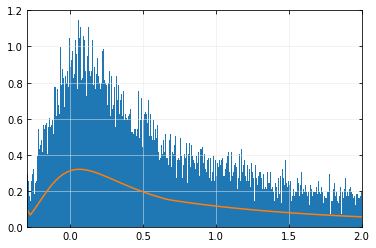

In [138]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.grid(b=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9', zorder=0)
ax.tick_params(axis='both', bottom=True, top=True, left=True, right=True, direction='in', which='both')

ax.hist(sample, bins = np.linspace(np.min(w),2,500), density = True)
ax.plot(w,g)

ax.set_xlim(np.min(w),2)

plt.show()

**Run Monte Carlo experiment**

In [169]:
# Parameters
N = 10_000
reps = 10_000

# Initialize
G_new = np.empty(shape=reps) # Improved estimator
G_np = np.empty(shape=reps) # Non-parametric estimator

# Loop over reps
for j in range(reps):
    
    # Draw sample using accept-reject
    sample = funcs.act_rejct(N,c_max,h,f)
    
    ## Compute nonparametric gini ## 
    
    G_np[j] = funcs.gini(sample)
    
    ## Compute improved gini ##
    
    # The (1-p)'th percentile
    P = 0.0025
    u = np.percentile(sample,100*(1-P))
    
    # Compute s
    x_low = sample[sample<u] # Is this needed?
    E_low = np.mean(sample[sample<u])
    S = alpha/(alpha-1)*u*P / (alpha/(alpha-1)*u*P + E_low * (1-P))

    # Compute the Gini for top and bottom of sample
    G_high = 1/(2*alpha-1)
    G_low = funcs.gini(sample[sample<u])
    
    # Collect these
    G_new[j] = G_high*P*S + G_low*(1-P)*(1-S) + S - P

Plot the resulting distribution of Gini coefficient estimators

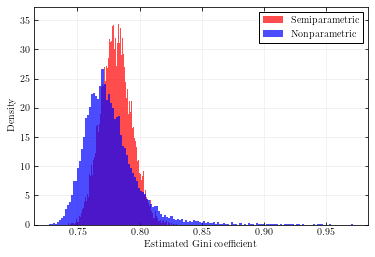

In [330]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.grid(b=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9', zorder=0)
ax.tick_params(axis='both', bottom=True, top=True, left=True, right=True, direction='in', which='both')

ax.hist(G_new, density = True, bins = 150, color = 'red', alpha = 0.7, zorder = 2, label='Semiparametric',  histtype='stepfilled')
ax.hist(G_np, density = True, bins = 150, color = 'blue', alpha = 0.7, zorder = 2, label='Nonparametric',  histtype='stepfilled')

# ax.set_ylim(0,100)
# ax.set_xlim(0.65,1)

ax.set_xlabel(r'Estimated Gini coefficient')
ax.set_ylabel(r'Density')

ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

plt.savefig('../../tex/figs/model_estimator.pdf')

# Create Time seris of estimates

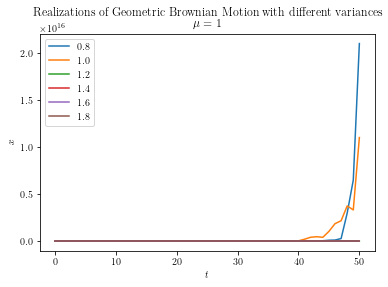

In [266]:
mu = 1
n = 50
dt = 1.0
x0 = 100
np.random.seed(1)

sigma = np.arange(0.8, 2, 0.2)

# Using Itos solution
x = np.exp(
    (mu - sigma ** 2 / 2) * dt
    + sigma * np.random.normal(0, np.sqrt(dt), size=(len(sigma), n)).T
)
x = np.vstack([np.ones(len(sigma)), x])
x = x0 * x.cumprod(axis=0)

plt.plot(x)
plt.legend(np.round(sigma, 2))
plt.xlabel("$t$")
plt.ylabel("$x$")
plt.title(
    "Realizations of Geometric Brownian Motion with different variances\n $\mu=1$"
)
plt.show()

In [294]:
# Set parameter values
lamdaa = 0.5
gamma = 0.2
rho = 0.05
R = 0.051
r = 0.041
zeta = 1.5
sigma2 = (zeta/gamma + 1)/2*(R-r)**2/(rho - r)
sigma = sigma2**(1/2)

z1 = .01
z2 = 3*z1

Create policy functions by interpolation

In [247]:
# Load policy functions
df_b = pd.read_csv(r'saving.csv', header=None)
df_k = pd.read_csv(r'risky.csv', header=None)


# Save as a numpy array
adot = df_b.to_numpy().transpose() # Rows are now types, columns are asset levels
k = df_k.to_numpy().transpose()

In [248]:
adot_interp_1 = interpolate.RegularGridInterpolator([w_bottom], adot[0,:], bounds_error=False,fill_value=None)
adot_interp_2 = interpolate.RegularGridInterpolator([w_bottom], adot[1,:], bounds_error=False,fill_value=None)
k_interp_1 = interpolate.RegularGridInterpolator([w_bottom], k[0,:], bounds_error=False,fill_value=None)
k_interp_2 = interpolate.RegularGridInterpolator([w_bottom], k[1,:], bounds_error=False,fill_value=None)

Run Monte Carlo

In [325]:
# Set simulation parameters
N = 5000
T = 1000

theta = (R-r)/(gamma*sigma2) # Share of risky assets

# Load agents from the stationary wealth distribution
wealth = funcs.act_rejct(N,c_max,h,f)

# Loop over time
for t in range(T):
    
    # Riskless return
    riskless_next = (1+r)*wealth
    risky_next = (z1+z2)/2 + (1 + R - sigma2/2 + sigma*np.random.normal(0,1,size=len(wealth)))*wealth
    
    # Combine with shares
    wealth = (1-theta)*riskless_next + theta*risky_next

In [326]:
np.max(wealth)

1.6580272106393706e+16

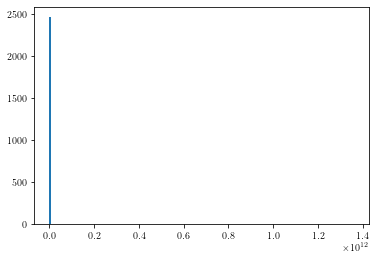

In [322]:
plt.hist(wealth, bins = 150)
# plt.xlim(0,100)
plt.show()

In [295]:
# Set simulation parameters
N = 2000
T = 5000

# Load agents from the stationary wealth distribution
sample = funcs.act_rejct(N,c_max,h,f)

# Loop over time periods
for t in range(T):
    
    # Draw stochastic numbers
    shift_rand = np.random.uniform(0,1,size=len(sample)) # Income type
    return_rand = sigma*np.random.normal(0,1,size=len(sample)) # Risky excess return
    
    # Compute next periods wealth
    k_next_1 = k_interp_1(sample[shift_rand < 0.5])*return_rand[shift_rand < 0.5]
    k_next_2 = k_interp_2(sample[shift_rand >= 0.5])*return_rand[shift_rand >= 0.5]
    
    wealth_next_1 = z1 + 1 + adot_interp_1(sample[shift_rand < 0.5]) + k_next_1
    wealth_next_2 = z2 + 1 + adot_interp_1(sample[shift_rand >= 0.5 ]) + k_next_2
    
    # Update sample
    sample[shift_rand < 0.5] = wealth_next_1
    sample[shift_rand >= 0.5] = wealth_next_2

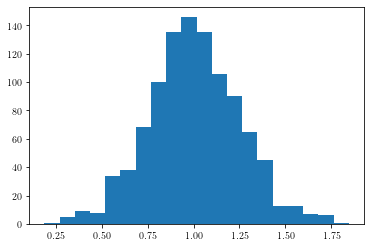

In [296]:
plt.hist(sample, bins = 20)
plt.show()